<a href="https://colab.research.google.com/github/tnc-br/ddf_common/blob/furthest_points/partitioned_dataset_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Imports and modules.
%pip install opencv-python
%pip install matplotlib
%pip install pandas

from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import matplotlib.animation as animation
from matplotlib import rc
from typing import List
from numpy.random import MT19937, RandomState, SeedSequence
import pandas as pd
from tqdm import tqdm
from io import StringIO
import xgboost as xgb
import os
import math
import glob

rc('animation', html='jshtml')

import sys
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_source_control_pane()
# ddfimport.ddf_import_common()

interactive(children=(Text(value='', description='Email', placeholder='Enter email'), Text(value='', descripti…

In [20]:
import partitioned_dataset
import importlib
importlib.reload(partitioned_dataset)

<module 'partitioned_dataset' from '/content/gdrive/MyDrive/furthest_points/ddf_common/partitioned_dataset.py'>

In [9]:
from pandas.testing import assert_frame_equal

def test_partition_data_fixed():
  '''
  For reference:
  _FIXED_PARTITION_STRATEGY = FixedPartitionStrategy(
    # Train
    DatasetGeographicPartitions(
        min_longitude=-62.5,
        max_longitude=float('inf'),
        min_latitude=-5,
        max_latitude=float('inf'),
    ),
    # Validation
    DatasetGeographicPartitions(
        min_longitude=float('-inf'),
        max_longitude=-62.5,
        min_latitude=-5,
        max_latitude=float('inf')
    ),
    # Test
    DatasetGeographicPartitions(
        min_longitude=float('-inf'),
        max_longitude=float('inf'),
        min_latitude=float('-inf'),
        max_latitude=-5
    )
  )
  '''
  train_long_values = [-62.5, -50.0, -20.0, 0.0, 100.0]
  train_lat_values = [-5.0, -3.0, -2.0, -1.0, 0.0]

  validation_long_values = [-80.0, -70.0, -63.0]
  validation_lat_values = [-5.0, -2.0, 5.0]

  test_long_values = [-50.0, -30.0, -40.0, 0.0, 50.0, 100.0]
  test_lat_values = [-50.0, -30.0, -40.0, -20.0, -10.0, -5.1]

  test_data = pd.DataFrame({
      "long": train_long_values + test_long_values + validation_long_values,
      "lat": train_lat_values + test_lat_values + validation_lat_values,
  })

  resulting_dataset = partitioned_dataset.partition(
      test_data, partitioned_dataset.PartitionStrategy.FIXED)

  assert_frame_equal(
      resulting_dataset.train.reset_index(drop=True),
      pd.DataFrame({
          "long": train_long_values,
          "lat": train_lat_values,
      }).reset_index(drop=True)
  )
  assert_frame_equal(
      resulting_dataset.validation.reset_index(drop=True),
      pd.DataFrame({
          "long": validation_long_values,
          "lat": validation_lat_values,
      }).reset_index(drop=True)
  )
  assert_frame_equal(
      resulting_dataset.test.reset_index(drop=True),
      pd.DataFrame({
          "long": test_long_values,
          "lat": test_lat_values,
      }).reset_index(drop=True)
  )

test_partition_data_fixed()

In [10]:
def test_partition_data_random():
  '''
  For reference:
  TRAIN_VALIDATION_TEST_RATIOS = [0.8, 0.1, 0.1]
  '''

  test_data = pd.DataFrame({
      "long": [-62.5, -50.0, -20.0, 0.0, 100.0, -62.5, -50.0, -20.0, 0.0, 100.0],
      "lat": [-5.0, -3.0, -2.0, -1.0, 0.0, -5.0, -3.0, -2.0, -1.0, 0.0],
  })

  resulting_dataset = partitioned_dataset.partition(
      test_data, partitioned_dataset.PartitionStrategy.RANDOM)

  assert(resulting_dataset.train.shape[0] == 8)
  assert(resulting_dataset.validation.shape[0] == 1)
  assert(resulting_dataset.test.shape[0] == 1)

test_partition_data_random()

In [12]:
import pytest

def test_partition_data_furthest_points_not_enough_data():
  with pytest.raises(ValueError):
    test_data = pd.DataFrame({
      "long": [-62.5, -50.0, -20.0, 0.0, 100.0],
      "lat": [-5.0, -3.0, -2.0, -1.0, 0.0],
    })
    _ = partitioned_dataset.partition(
        test_data, partitioned_dataset.PartitionStrategy.FURTHEST_POINTS)

test_partition_data_furthest_points_not_enough_data()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


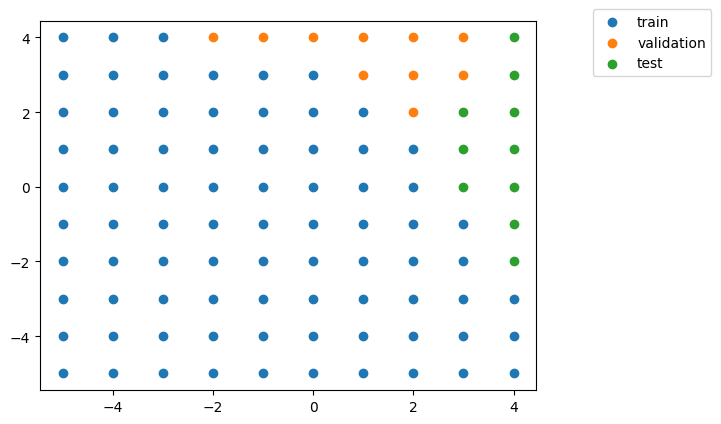

In [21]:
import matplotlib.pyplot as plt

np.random.seed(123)

def test_partition_data_furthest_points():
  longs = []
  lats = []
  for long in range(-5, 5, 1):
    for lat in range(-5, 5, 1):
      longs.append(long)
      lats.append(lat)
  test_data = pd.DataFrame({
    "long": longs,
    "lat": lats,
  })
  resulting_dataset = partitioned_dataset.partition(test_data,
                        partitioned_dataset.PartitionStrategy.FURTHEST_POINTS)

  assert(resulting_dataset.train.shape[0] == 80)
  assert(resulting_dataset.validation.shape[0] == 10)
  assert(resulting_dataset.test.shape[0] == 10)
  plt.scatter(
      resulting_dataset.train['long'],
      resulting_dataset.train['lat'],
      label='train'
  )
  plt.scatter(
      resulting_dataset.validation['long'],
      resulting_dataset.validation['lat'],
      label='validation'
  )
  plt.scatter(
      resulting_dataset.test['long'],
      resulting_dataset.test['lat'],
      label='test'
  )
  plt.legend(bbox_to_anchor=(1.1, 1.05))

test_partition_data_furthest_points()